# 0.0 START

## 0.1 Imports

In [77]:
import math
import random
import pandas as pd
import inflection
import numpy as np
import datetime
import seaborn as sns
import xgboost as xgb
import warnings
warnings.filterwarnings ('ignore')

from scipy import stats as ss
from tabulate import tabulate
from boruta import BorutaPy

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gs
%matplotlib inline

from IPython.core.display import HTML
from IPython.display import Image

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

import pickle

## 0.2 Helper functions

In [82]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def cramers_v(x, y):
    cm = pd.crosstab(x, y).as_matrix()
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def mean_absolute_percentage_error(y, yhat):
     return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({'Model name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])
    
    
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use('dark')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)

    sns.set()

## 0.3 Loading data

In [3]:
# df = dataframe
# raw = without any modificantion
# read_csv is a function used with pandas library
df_sales_raw = pd.read_csv('../data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

${appName}: ${sessionName}## 0.4 Colors

In [4]:
# colors used in the project

red = '#F15854'
blue = '#5DA5DA'
orange = '#FAA43A'
green = '#60BD68'
pink = '#F17CB0'
brown = '#B2912F'
purple = '#B276B2'
yellow = '#DECF3F'
gray = '#4D4D4D'

# plot size
figsize = (20, 15)

# 1.0 DATA DESCRIPTION

## 1.0.1 Dataset copy

In [5]:
# always create a copy of the df
df1 = df_raw.copy()

## 1.1 Data fields

*Id*: an Id that represents a (Store, Date) duple within the test set

*Store*: a unique Id for each store

*Sales*: the turnover for any given day (this is what you are predicting)

*Customers*: the number of customers on a given day

*Open*: an indicator for whether the store was open: 0 = closed, 1 = open

*State Holiday*: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

*School Holiday*: indicates if the (Store, Date) was affected by the closure of public schools

*Store Type*: differentiates between 4 different store models: a, b, c, d

*Assortment*: describes an assortment level: a = basic, b = extra, c = extended

*Competition Distance*: distance in meters to the nearest competitor store

*Competition Open Since Month/Year*: gives the approximate year and month of the time the nearest competitor was opened

*Promo*: indicates whether a store is running a promo on that day

*Promo 2*: Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

*Promo 2 Since Year/Week*: describes the year and calendar week when the store started participating in Promo2

*Promo Interval*: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## 1.2 Rename columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
            'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']


def snakecase(x):
    return inflection.underscore(x)


# using the snakecase type
cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new

## 1.3 Data dimensions

In [7]:
print(f'Number of rows: {df1.shape[0]} \nNumber of columns: {df1.shape[1]}')

Number of rows: 1017209 
Number of columns: 18


## 1.4 Data types

In [8]:
# changing the date type from object to datetime
df1['date'] = pd.to_datetime(df1['date'])

data_types = pd.DataFrame(df1.dtypes).reset_index()
data_types

,index,0
0,store,int64
1,day_of_week,int64
2,date,datetime64[ns]
3,sales,int64
4,customers,int64
5,open,int64
6,promo,int64
7,state_holiday,object
8,school_holiday,int64
9,store_type,object


## 1.5 Check NA

In [9]:
na_test = pd.DataFrame(df1.isna().sum()).reset_index()
na_test

,index,0
0,store,0
1,day_of_week,0
2,date,0
3,sales,0
4,customers,0
5,open,0
6,promo,0
7,state_holiday,0
8,school_holiday,0
9,store_type,0


In [10]:
# Need to fix the NA's in the columns competition_distance, competition_open_since_month, 
# competition_open_since_year, promo2_since_week, promo2_since_year and promo_interval

## 1.6 Fillout NA

In [11]:
max_value_competition_distance = df1['competition_distance'].max()
print(f'The max value in the column competition_distance is {max_value_competition_distance}!')

The max value in the column competition_distance is 75860.0!


In [12]:
# competition_distance
# for complete the NaN elements, just apply a lambda function with a value > df1['competition_distance'].max()
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 2000000.0
                                                                if math.isnan(x)
                                                                else x)

# competition_open_since_month
# change the NaN elements to date
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month
                                                if math.isnan(x['competition_open_since_month'])
                                                else x['competition_open_since_month'], axis=1)

# competition_open_since_year
# equal to competition_since_month
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year
                                               if math.isnan(x['competition_open_since_year'])
                                               else x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week 
                                     if math.isnan(x['promo2_since_week']) 
                                     else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year 
                                     if math.isnan(x['promo2_since_year']) 
                                     else x['promo2_since_year'], axis=1)


# promo_interval
# changing names of month to numbers makes the manipulation easier
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',
             7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

promo_interval_fill_na = df1['promo_interval'].fillna(0, inplace=True)

# there's a list, use .map instead of .apply
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
    lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

## 1.7 Change types

In [13]:
# converting competition_open_since_month, competition_open_since_year, promo2_since_week, promo2_since_year  from float to int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(
    int)

df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(
    int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.8 Descriptive statistical

In [14]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(
    exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.8.1 Numerical attributes

In [15]:
# * Central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#* Dispersion - std, min, max, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T


#! Range is the difference between the max value and min value
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T

d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# * Concat
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range',
             'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,2000000.0,1999980.0,10610.588099,2330.0,101810.649100,19.378002,375.644405
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


[Text(0.5, 114.0, '')]

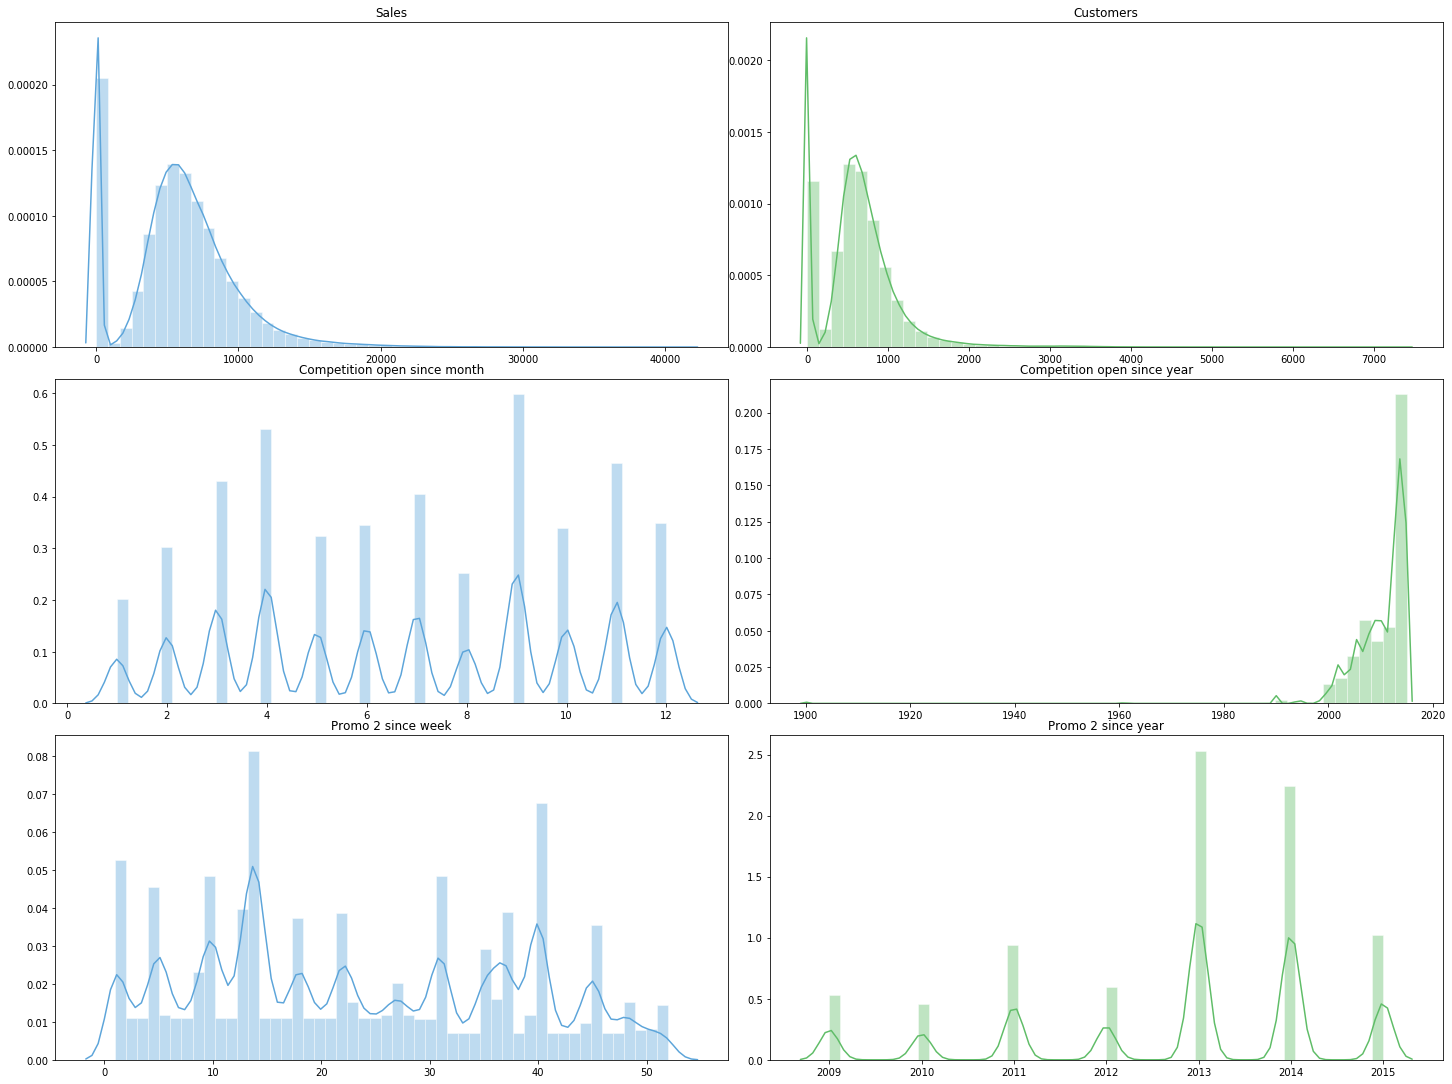

In [16]:
# Using subplot and adjusting the size of the plots
fig1, axes = plt.subplots(3, 2, figsize=figsize)
fig1.tight_layout()

# Sales
sns.set_style('dark')
dist_sales = sns.distplot(df1['sales'], color=blue, ax=axes[0, 0])
dist_sales.set_title('Sales')
dist_sales.set(xlabel='')

# Customers
dist_customers = sns.distplot(df1['customers'], color=green, ax=axes[0, 1])
dist_customers.set_title('Customers')
dist_customers.set(xlabel='')

# Competition Open Since Month
dist_competition_open_since_month = sns.distplot(
    df1['competition_open_since_month'], color=blue, ax=axes[1, 0])
dist_competition_open_since_month.set_title('Competition open since month')
dist_competition_open_since_month.set(xlabel='')

# Competition Open Since Year
dist_competition_open_since_year = sns.distplot(
    df1['competition_open_since_year'], color=green, ax=axes[1, 1])
dist_competition_open_since_year.set_title('Competition open since year')
dist_competition_open_since_year.set(xlabel='')

# Promo 2 Since Week
dist_promo2_since_week = sns.distplot(
    df1['promo2_since_week'], color=blue, ax=axes[2, 0])
dist_promo2_since_week.set_title('Promo 2 since week')
dist_promo2_since_week.set(xlabel='')

# Promo 2 Since Year
dist_promo2_since_year = sns.distplot(
    df1['promo2_since_year'], color=green, ax=axes[2, 1])
dist_promo2_since_year.set_title('Promo 2 since year')
dist_promo2_since_year.set(xlabel='')

### 1.8.2 Categorical attributes

In [17]:
#! List of categorical attributes
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

[Text(0, 0.5, ''), Text(0.5, 0, 'Assortment')]

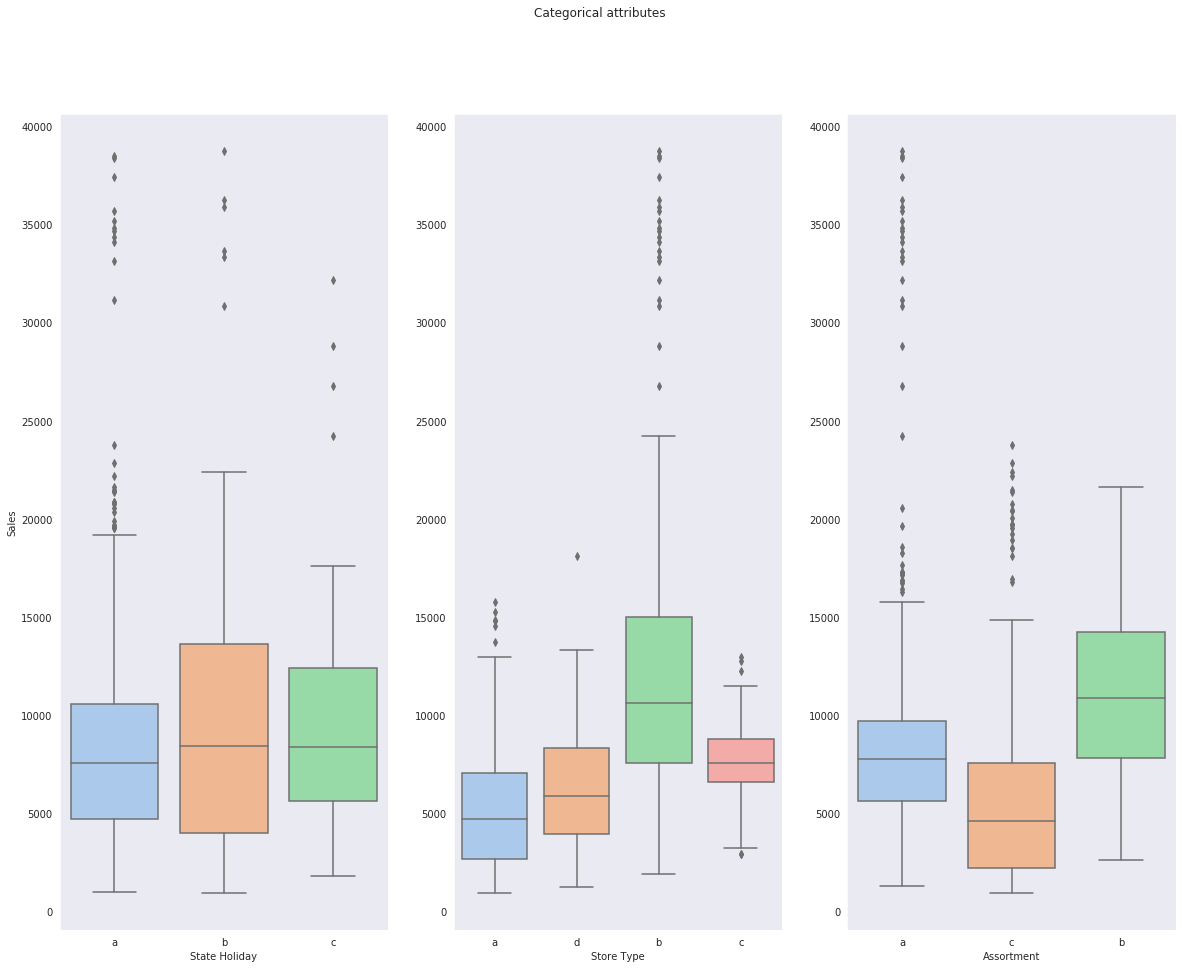

In [18]:
#! Conditions
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

# Using subplot and adjusting the size of the plots
fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
fig2.suptitle('Categorical attributes')

# Boxplot 1
sns.set_style("darkgrid")
bp_state_holiday = sns.boxplot(
    ax=ax1, data=aux, x='state_holiday', y='sales', palette='pastel')
bp_state_holiday.set(xlabel="State Holiday", ylabel="Sales")

# Boxplot 2
bp_store_type = sns.boxplot(
    ax=ax2, data=aux, x='store_type', y='sales', palette='pastel')
bp_store_type.set(xlabel="Store Type", ylabel="")

# Boxplot 3
bp_assortment = sns.boxplot(
    ax=ax3, data=aux, x='assortment', y='sales', palette='pastel')
bp_assortment.set(xlabel="Assortment", ylabel="")

# 2.0. FEATURE ENGINEERING

## 2.0.1 Dataset copy

In [19]:
# always create a copy of the df
df2 = df1.copy()

## 2.1. Mind map hypothesis

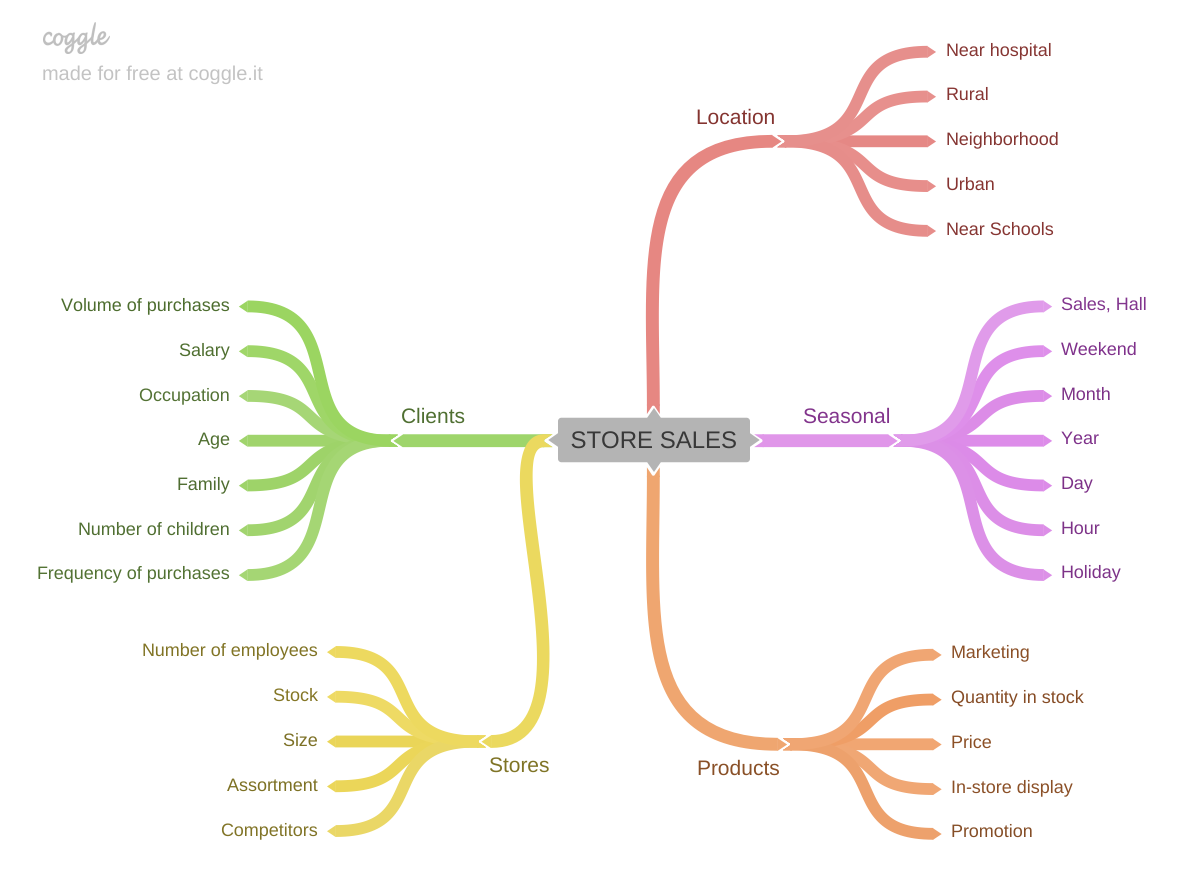

In [20]:
Image('../img/mind_map_hypothesis.png')

## 2.2. Hypothesis creation

### 2.2.1 Store hypothesis

**1.** Stores with more employees should sell more.

**2.** Stores with more stock capacity should sell more.

**3.** Larger stores should sell more.

**4.** Stores with a larger assortment should sell more.

**5** Stores with closer competitors should sell less.

**6** Stores dealing with competitors for a long time should sell more.


### 2.2.2 Product hypothesis

**1.** Stores that invest more in Marketing should sell more.

**2.** Stores with a huge product exposure should sell more.

**3.** Stores with lower priced products should sell more should sell more.

**4.** Stores with more aggressive promotions (bigger discounts), should sell more.

**5.** Stores with active promotions for more time should sell more.

**6.** Stores with more promotion days should sell more.

**7.** Stores with more consecutive promotions should sell more.

### 2.2.3 Seasonal hypothesis

**1.** Stores open during the Christmas holiday should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more after the 10th of each month.

**4.** Stores should sell more in the second half of the year.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

## 2.3 Hypothesis final list

**1.** Stores with a larger assortment should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores with active promotions for longer should sell more.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open during the Christmas holiday should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more after the 10th of each month.

**10.** Stores should sell more in the second half of the year.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

## 2.4 Feature engineering

In [21]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#  year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(
    year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = (
    (df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(
    str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(
    x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = (
    (df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(
    lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(
    lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0 VARIABLE FILTERING


## 3.0.1 Dataset copy

In [22]:
# always create a copy of the df
df3 = df2.copy()

In [23]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Line filtering

In [24]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Column Selection

In [25]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [26]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 EXPLORATORY DATA ANALYSIS

## 4.0.1 Dataset copy

In [27]:
df4 = df3.copy()

## 4.1 Univariate analysis

### 4.2.1 Response variable

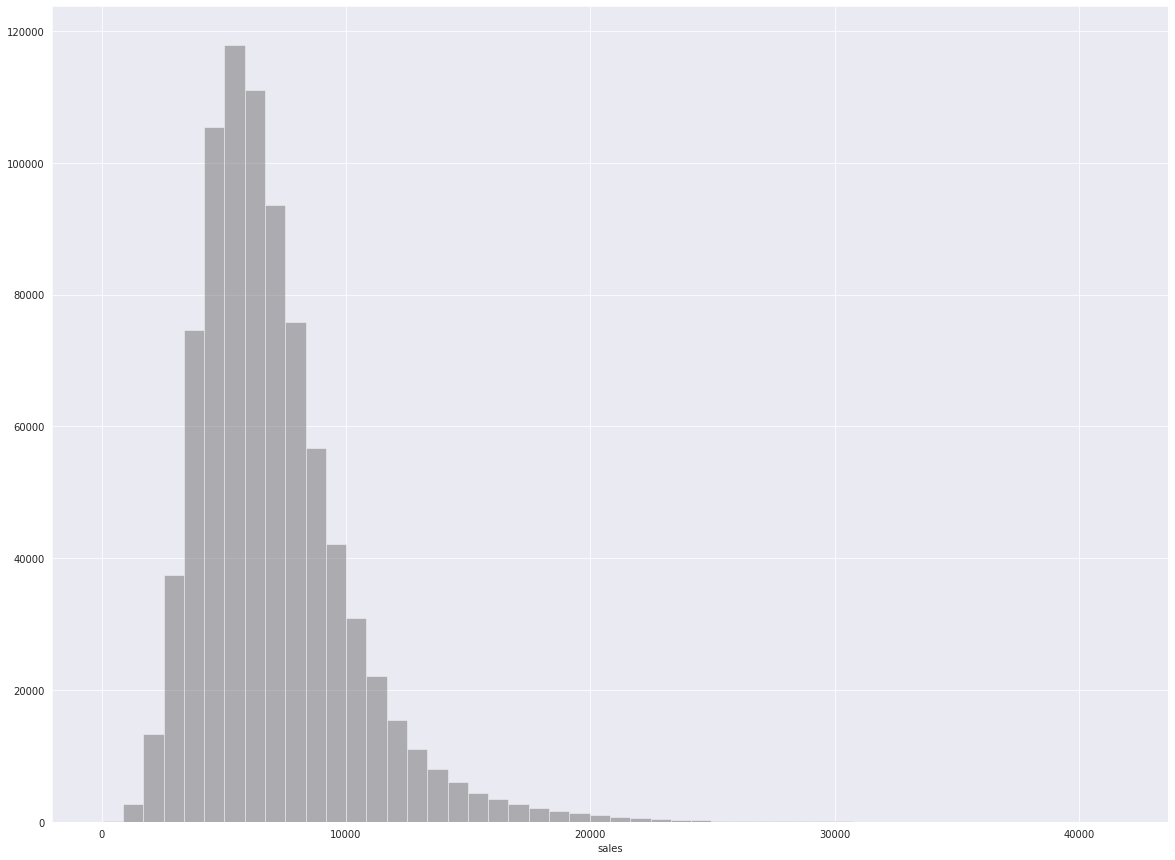

In [28]:
plt.figure(figsize=figsize)
dp_sales = sns.distplot(df4['sales'], color=gray, kde=False)

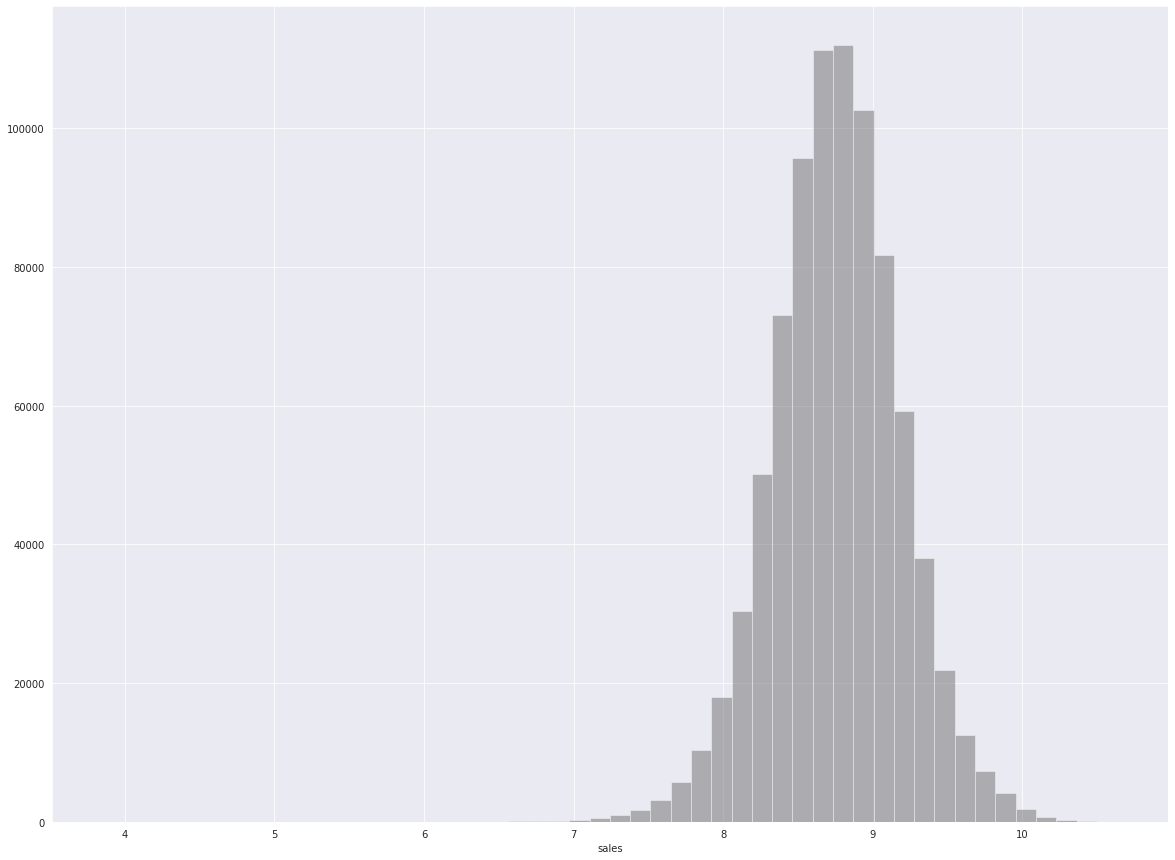

In [29]:
plt.figure(figsize=figsize)
sns.distplot(np.log1p(df4['sales']), color=gray, kde=False)

### 4.2.2 Numerical variable

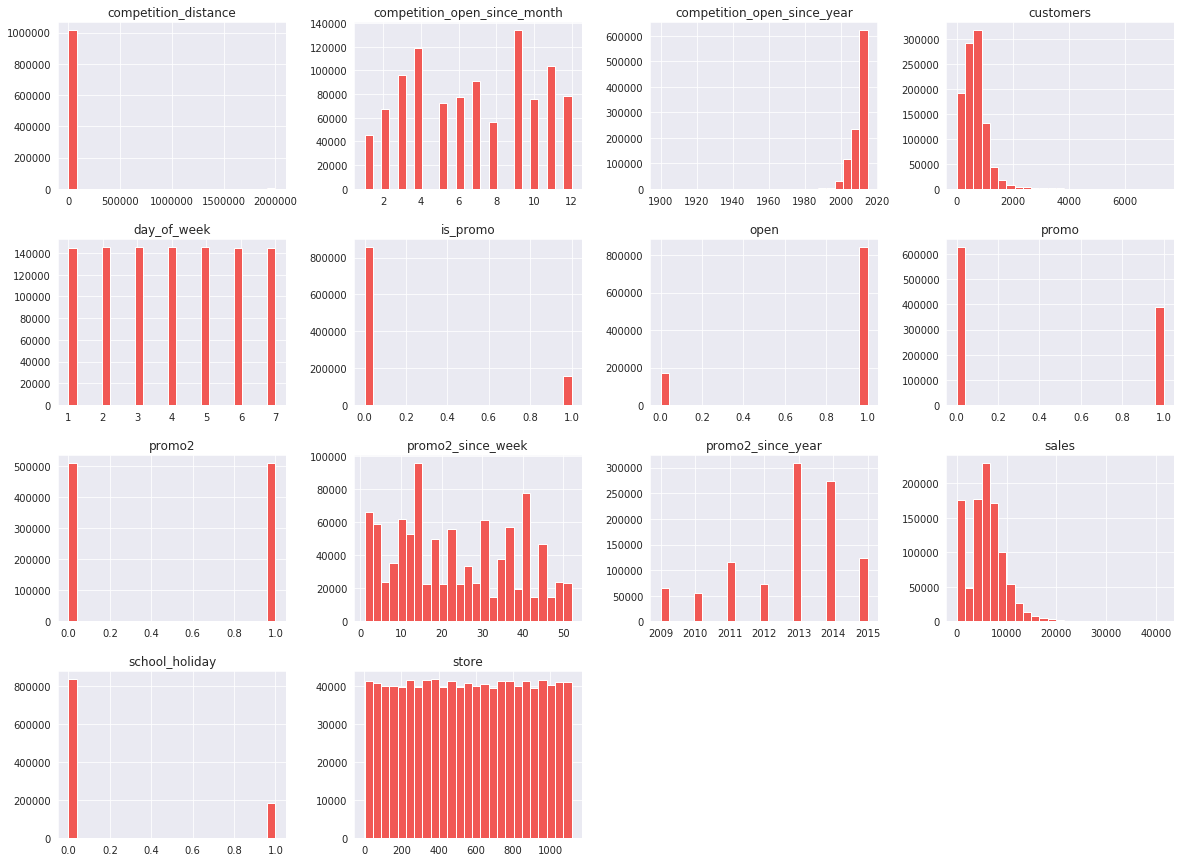

In [30]:
num_attributes_hist = num_attributes.hist(bins=25, color=red, figsize=figsize)

### 4.2.3 Categorical variable

In [31]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [32]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

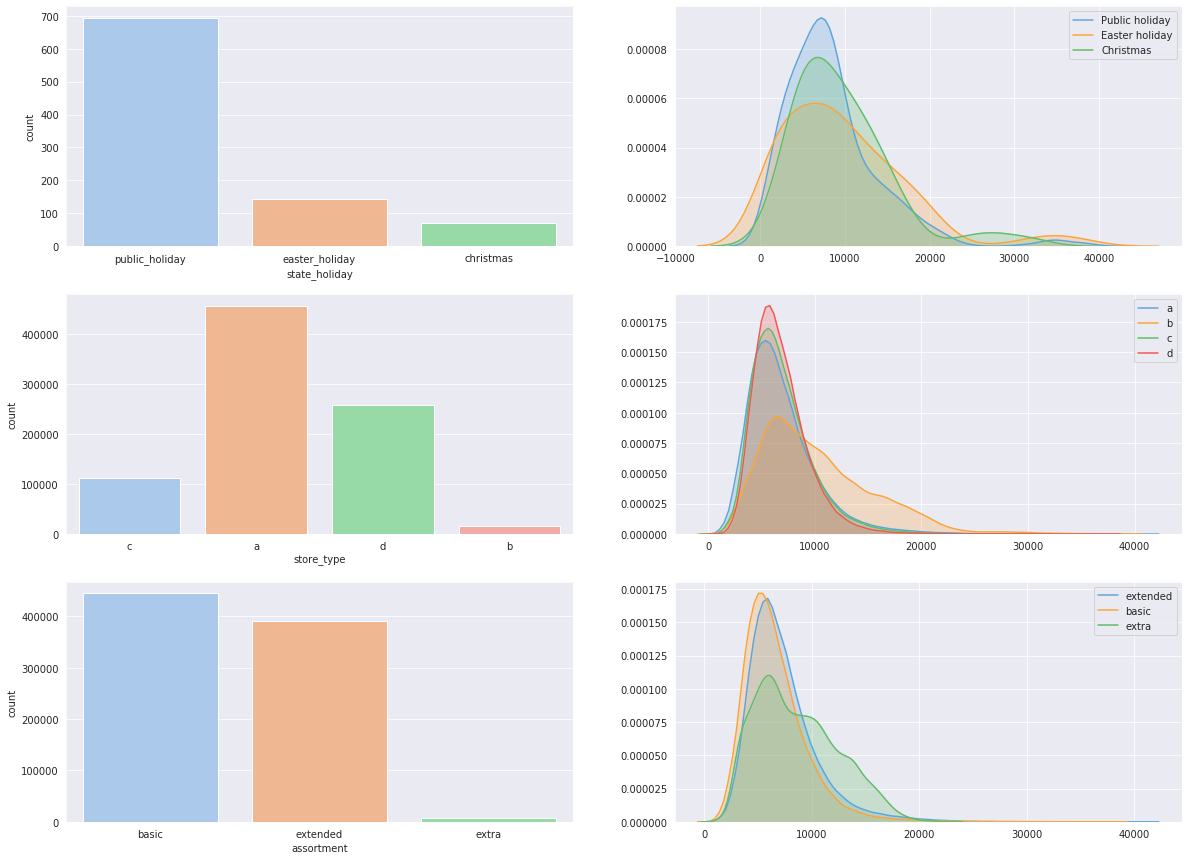

In [33]:
# Using subplot and adjusting the size of the plots
fig3, axes = plt.subplots(3, 2, figsize=(20, 15))
sns.set_style('dark')

# ---------------------------------------------------------------------------------------------------------------

# state_holiday
without_regular_day = df4[df4['state_holiday'] != 'regular_day']

wrd_countplot = sns.countplot(
    without_regular_day['state_holiday'], palette='pastel', ax=axes[0, 0])

sh_kdeplot1 = sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']
                          ['sales'], label='Public holiday', shade=True, color=blue, ax=axes[0, 1])
sh_kdeplot2 = sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']
                          ['sales'], label='Easter holiday', shade=True, color=orange, ax=axes[0, 1])
sh_kdeplot3 = sns.kdeplot(df4[df4['state_holiday'] == 'christmas']
                          ['sales'], label='Christmas', shade=True, color=green, ax=axes[0, 1])

# ---------------------------------------------------------------------------------------------------------------

# store_type
st_countplot = sns.countplot(
    df4['store_type'], palette='pastel', ax=axes[1, 0])


st_kdeplot1 = sns.kdeplot(df4[df4['store_type'] == 'a']['sales'],
                          label='a', shade=True, color=blue, ax=axes[1, 1])
st_kdeplot2 = sns.kdeplot(df4[df4['store_type'] == 'b']['sales'],
                          label='b', shade=True, color=orange, ax=axes[1, 1])
st_kdeplot3 = sns.kdeplot(df4[df4['store_type'] == 'c']['sales'],
                          label='c', shade=True, color=green, ax=axes[1, 1])
st_kdeplot4 = sns.kdeplot(df4[df4['store_type'] == 'd']
                          ['sales'], label='d', shade=True, color=red, ax=axes[1, 1])

# ---------------------------------------------------------------------------------------------------------------

# assortment
a_countplot = sns.countplot(df4['assortment'], palette='pastel', ax=axes[2, 0])


a_kdeplot1 = sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'],
                         label='extended', shade=True, color=blue, ax=axes[2, 1])
a_kdeplot2 = sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'],
                         label='basic', shade=True, color=orange, ax=axes[2, 1])
a_kdeplot3 = sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'],
                         label='extra', shade=True, color=green, ax=axes[2, 1])

## 4.2 Bivariate analysis

### H1. Stores with a larger assortment should sell more.
**FALSE** Stores with a LARGER ASSORTMENT sell LESS.

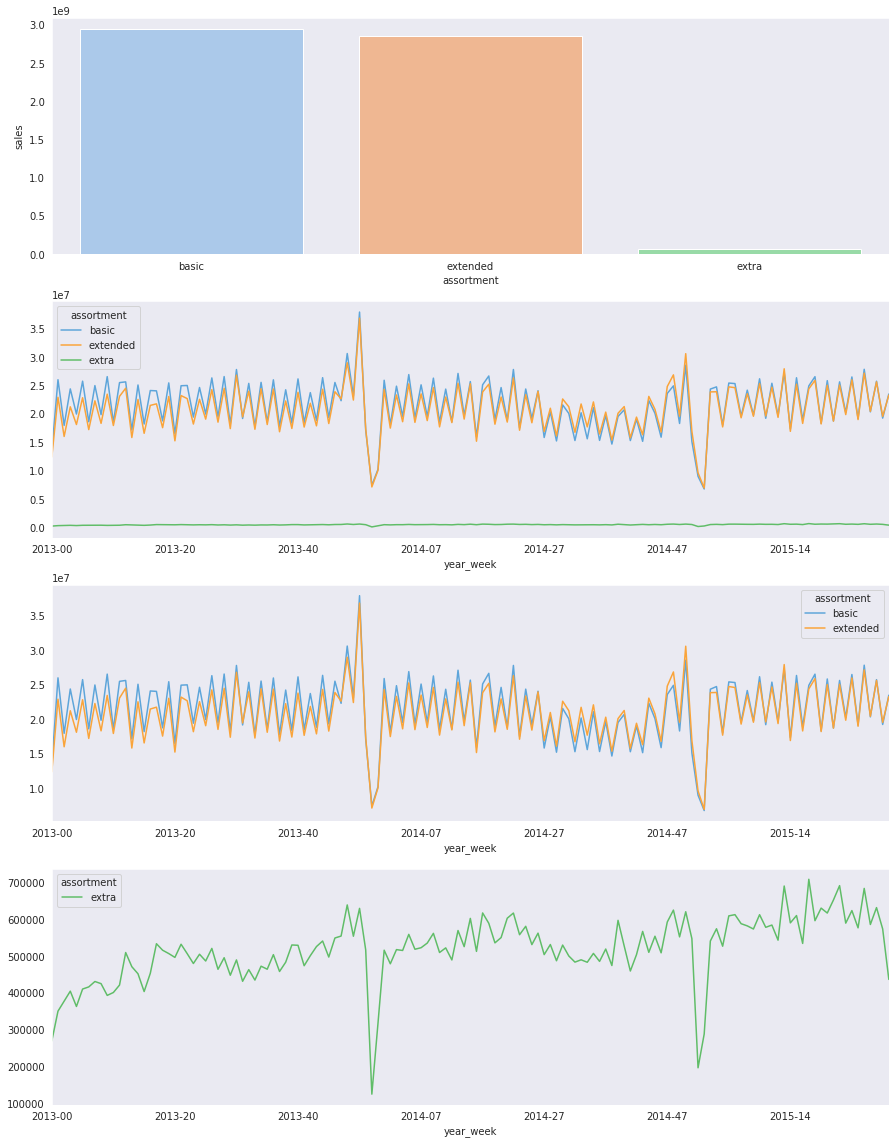

In [34]:
fig_h1, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 20))

# ---------------------------------------------------------------------------------------------------------------

sns.set_style('dark')
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
aux1_barplot = sns.barplot(ax=ax1, x='assortment',
                           y='sales', palette='pastel', data=aux1)

# ---------------------------------------------------------------------------------------------------------------

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(
    ['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot(
    ax=ax2, color=(blue, orange, green))

# ---------------------------------------------------------------------------------------------------------------

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment',
           values='sales').plot(ax=ax4, color=green)

# ---------------------------------------------------------------------------------------------------------------

aux4 = aux2[aux2['assortment'] != 'extra']
aux4.pivot(index='year_week', columns='assortment',
           values='sales').plot(ax=ax3, color=(blue, orange));

### **H2.** Stores with closer competitors should sell less.
**FALSE** Stores with CLOSER COMPETITORS sell MORE.

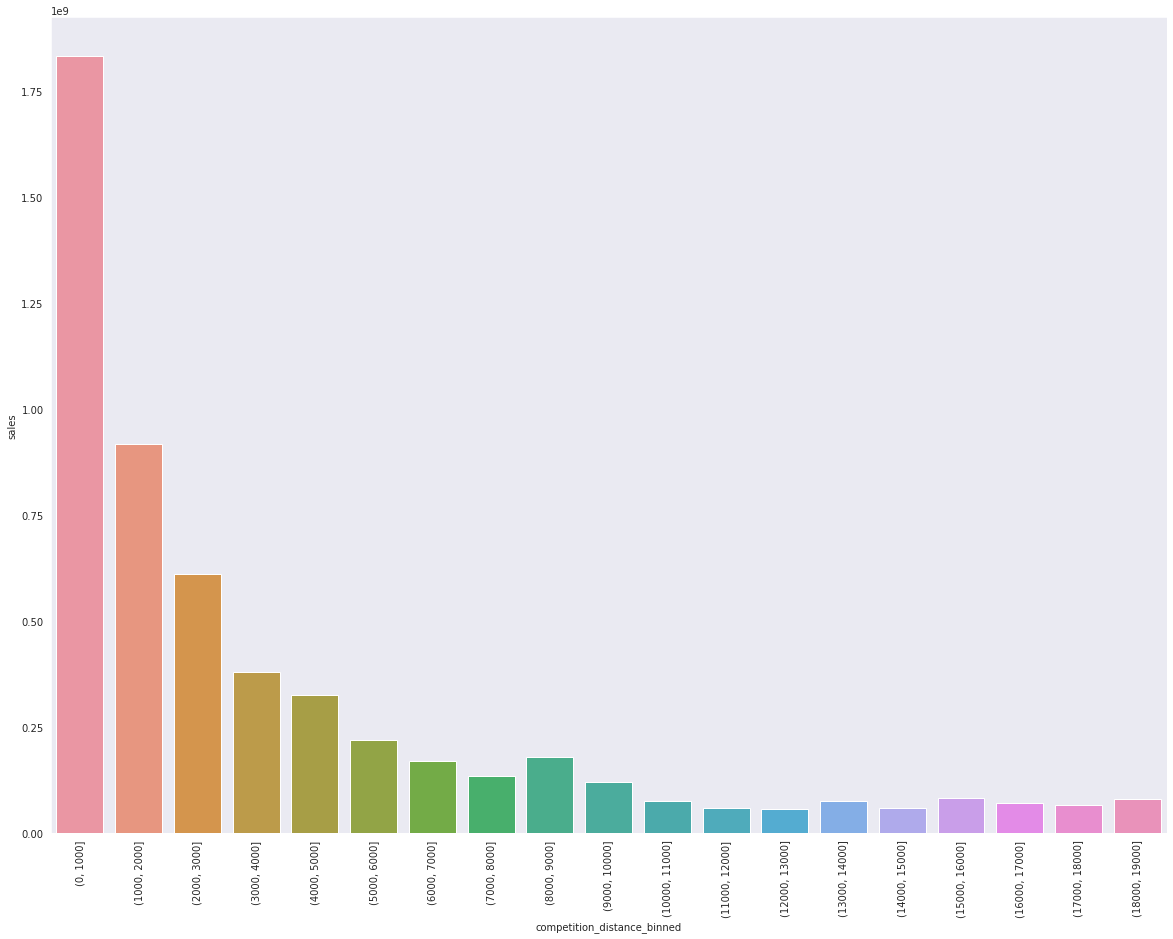

In [35]:
fig_h2, ax = plt.subplots(figsize=figsize)

sns.set_style('dark')
aux1 = df4[['competition_distance', 'sales']].groupby(
    'competition_distance').sum().reset_index()

# ---------------------------------------------------------------------------------------------------------------


bins = list(np.arange(0, 20000, 1000))

aux1['competition_distance_binned'] = pd.cut(
    aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby(
    'competition_distance_binned').sum().reset_index()
plt.xticks (rotation = 90)

aux1_barplot = sns.barplot(
    ax=ax, x='competition_distance_binned', y='sales', data=aux2);

### **H3.** Stores with long time competitors should sell more.
**FALSE** Stores with LONG TIME COMPETITORS sell LESS.

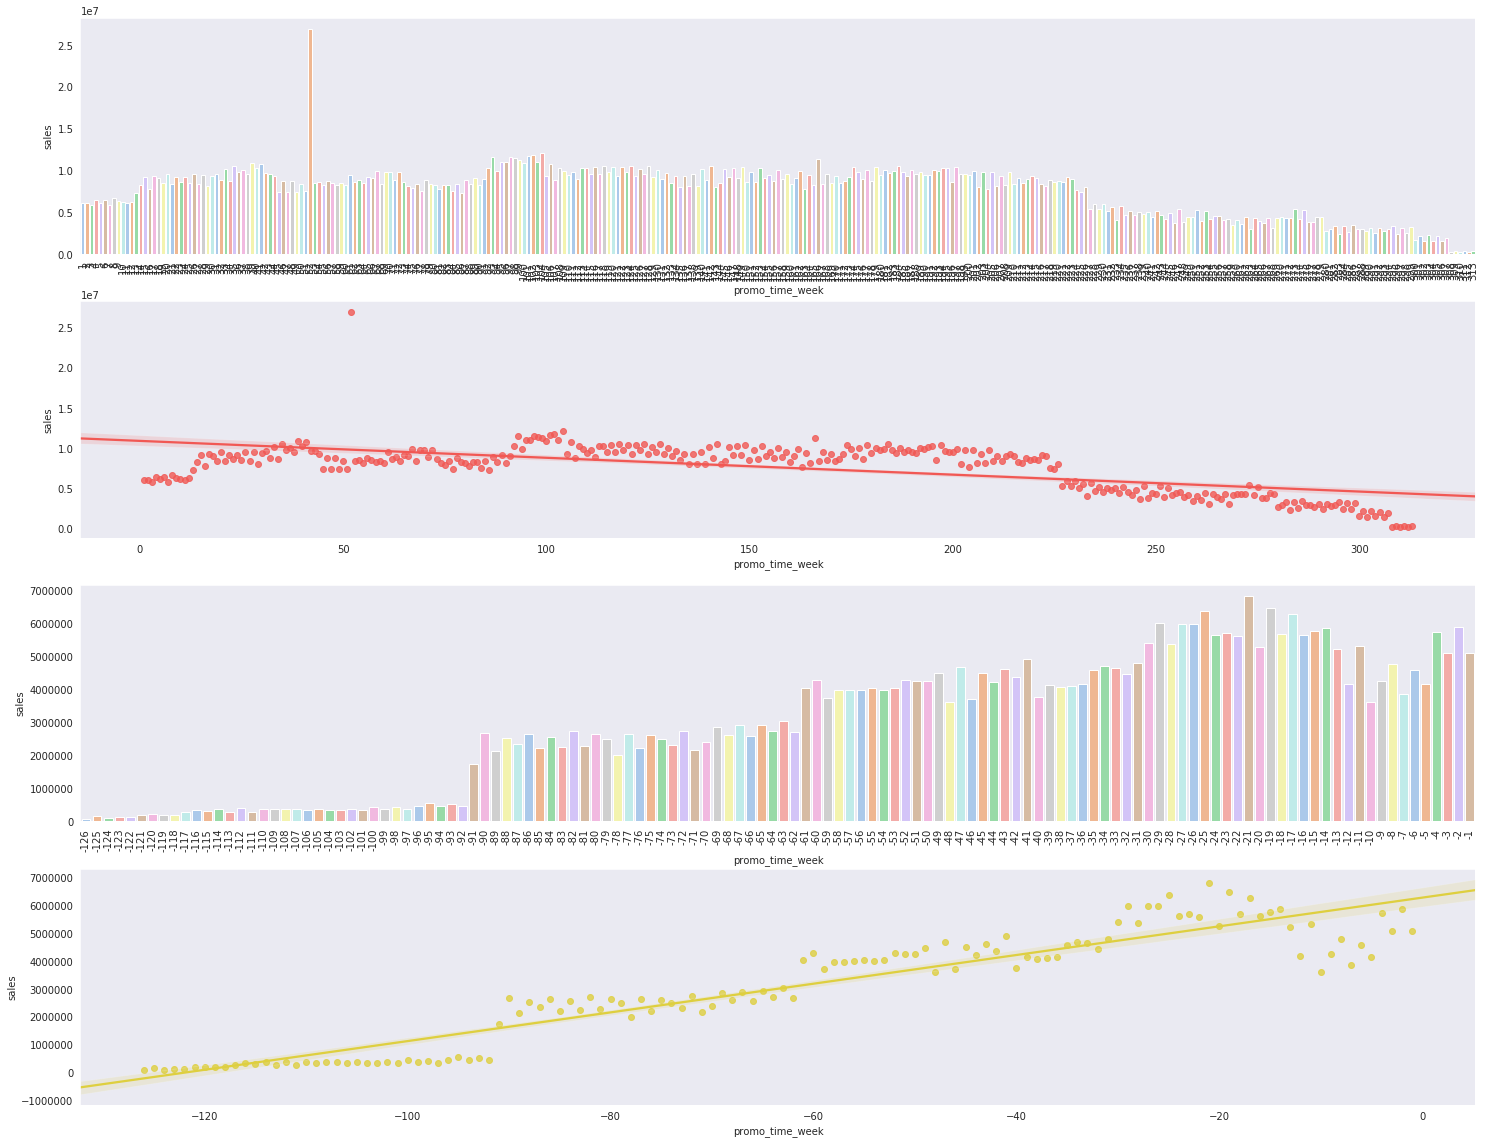

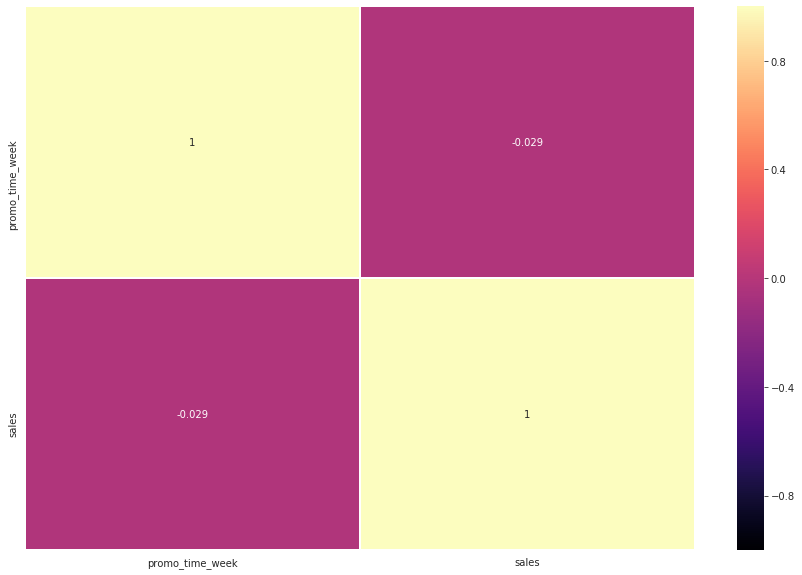

In [36]:
aux1 = df4[['promo_time_week', 'sales']].groupby(
    'promo_time_week').sum().reset_index()

fig_h3 = plt.figure(figsize=(25, 20))
grid1 = gs.GridSpec(4, 1, fig_h3)

# ---------------------------------------------------------------------------------------------------------------

plt.subplot(grid1[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0]  # promo extended
sns.barplot(data = aux2, x='promo_time_week', y='sales', palette='pastel')
plt.xticks(rotation=90)

plt.subplot(grid1[1, 0])
sns.regplot(data=aux2, x='promo_time_week', y='sales', color=red)

# ---------------------------------------------------------------------------------------------------------------

plt.subplot(grid1[2, 0])
aux3 = aux1[aux1['promo_time_week'] < 0]  # promo regular
sns.barplot(data=aux3, x='promo_time_week', y='sales', palette='pastel')
plt.xticks(rotation=90)

plt.subplot(grid1[3, 0])
sns.regplot(data=aux3, x='promo_time_week', y='sales', color=yellow)

# ---------------------------------------------------------------------------------------------------------------

fig_h3b = plt.figure(figsize=(15, 10))
grid2 = gs.GridSpec(1, 1, fig_h3b)
plt.subplot(grid2[0, 0])
sns.heatmap(aux1.corr(method='pearson'), linewidths=.5,
           vmin=-1, vmax=1, annot=True, cmap="magma")

### **H4.** Stores with active promotions for longer should sell more.
**FALSE** Stores with ACTIVE PROMOTIONS for longer sell LESS, after a certain time.

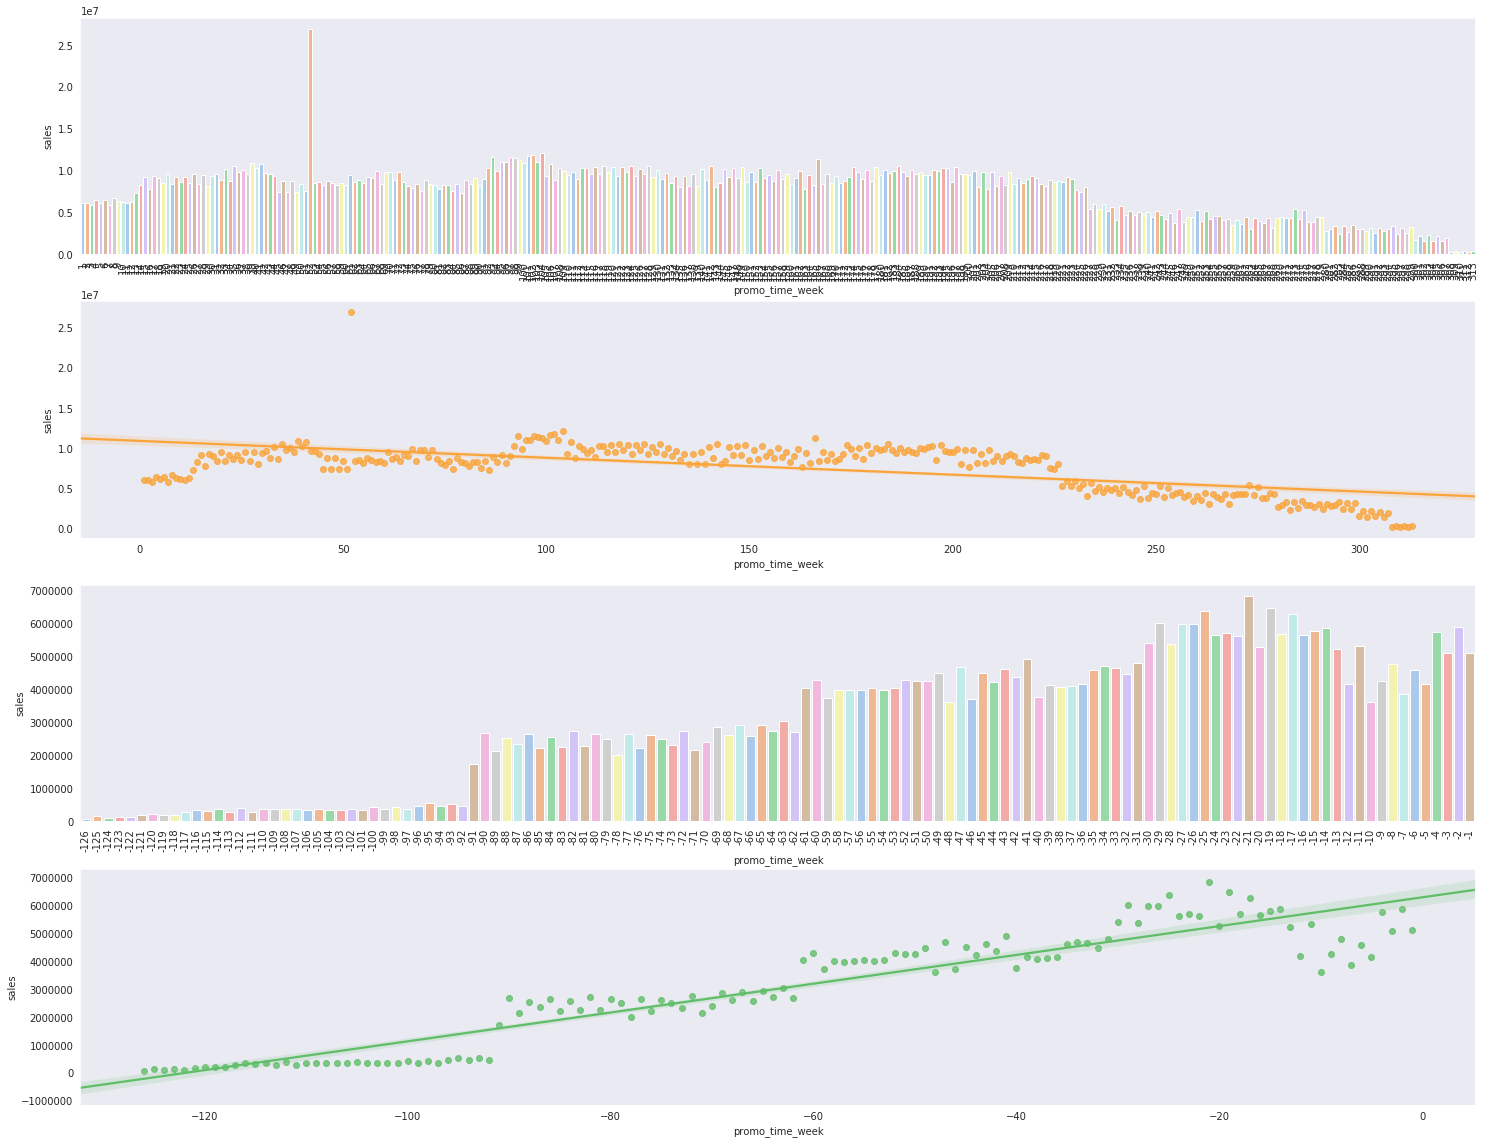

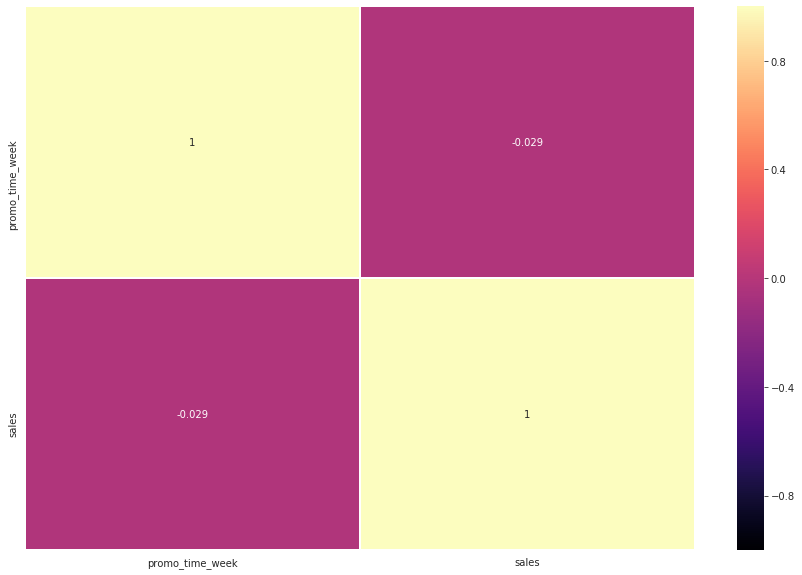

In [37]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

fig_h4 = plt.figure(figsize=(25, 20))
grid3 = gs.GridSpec( 4, 1, fig_h4 )

# ---------------------------------------------------------------------------------------------------------------

plt.subplot( grid3[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( data= aux2, x='promo_time_week', y='sales', palette='pastel');
plt.xticks( rotation=90 );

plt.subplot( grid3[1,0] )
sns.regplot(data= aux2, x='promo_time_week', y='sales', color = orange);

# ---------------------------------------------------------------------------------------------------------------

plt.subplot( grid3[2,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(data=aux3, x='promo_time_week', y='sales', palette='pastel');
plt.xticks( rotation=90 );

plt.subplot( grid3[3,0] )
sns.regplot( data=aux3, x='promo_time_week', y='sales', color = green);

# ---------------------------------------------------------------------------------------------------------------
fig_h4b = plt.figure(figsize=(15, 10))
grid4 = gs.GridSpec(1, 1, fig_h4b)
plt.subplot(grid4[0, 0])
sns.heatmap(aux1.corr(method='pearson'), linewidths=.5,
           vmin=-1, vmax=1, annot=True, cmap="magma")

### <s>**H5.** Stores with more days in promotion should sell more.</s>

### **H6.** Stores with more active promotions should sell more.
**FALSE** Stores with more ACTIVE PROMOTIONS sell LESS.

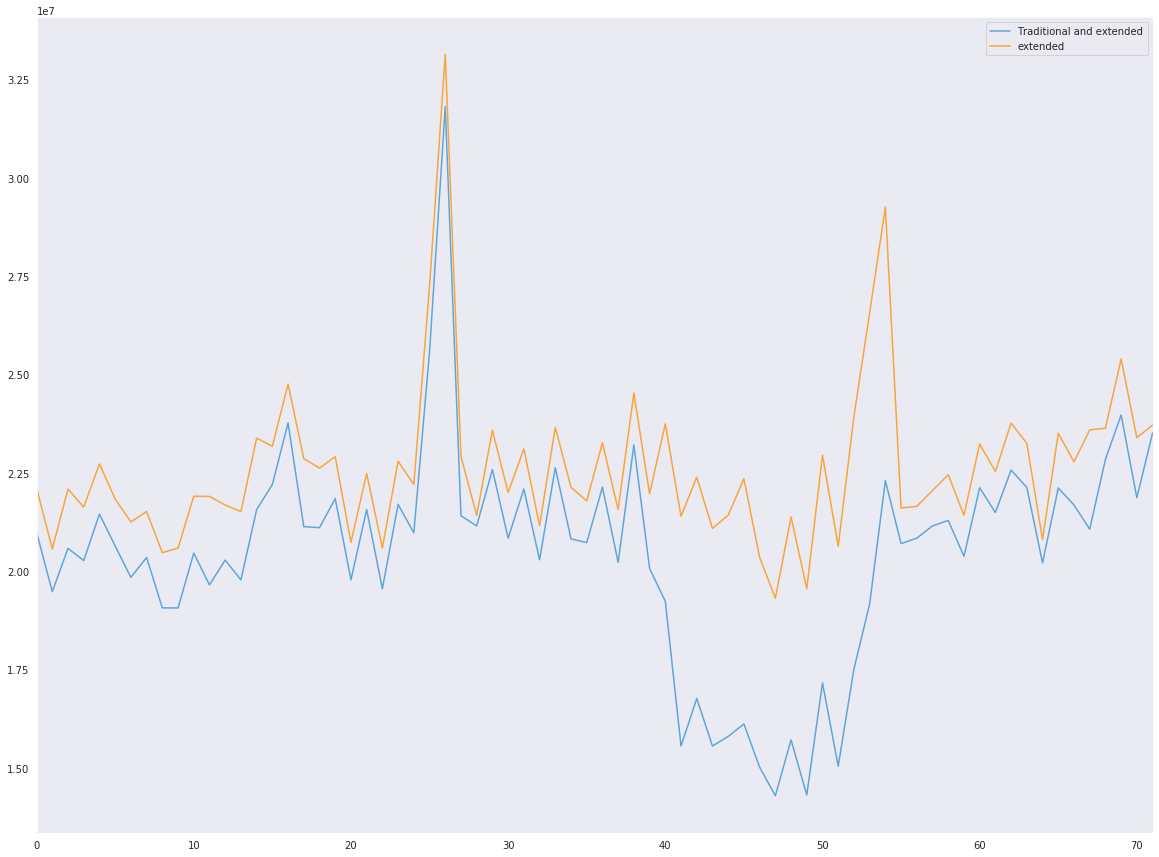

In [38]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

fig_h6, (ax) = plt.subplots(1, 1, figsize=figsize)

# ---------------------------------------------------------------------------------------------------------------

aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux1.plot(ax=ax, color=blue)

# ---------------------------------------------------------------------------------------------------------------

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax, color=orange )
ax.legend( labels=['Traditional and extended', 'extended']);

### **H7.** Stores open during christmas should sell more.
**FALSE** Stores OPEN DURING CHRISTMAS sell LESS.

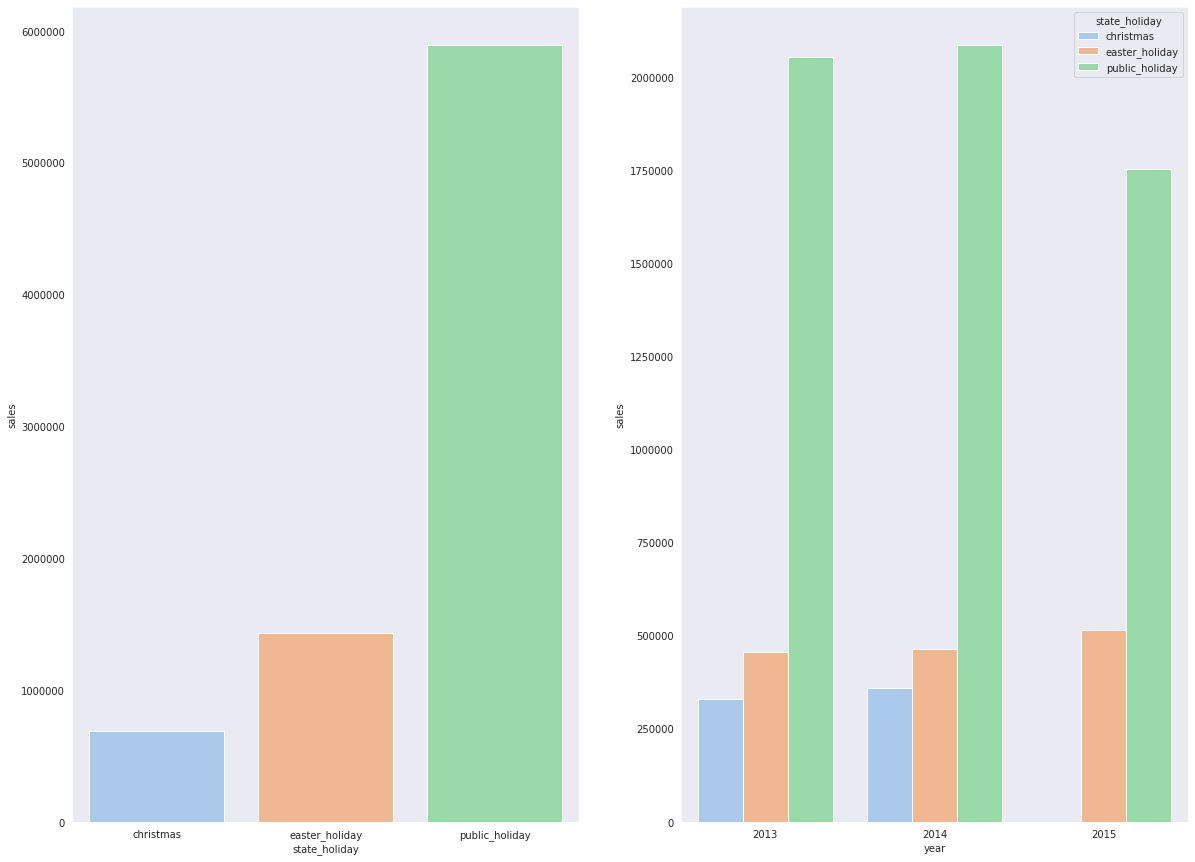

In [39]:
aux = df4[df4['state_holiday'] != 'regular_day']

fig_h7, (ax1, ax2) = plt.subplots(1, 2, figsize = figsize)
sns.set_style('dark')

# ---------------------------------------------------------------------------------------------------------------

aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot(ax=ax1, data=aux1, x='state_holiday', y='sales', palette='pastel');

# ---------------------------------------------------------------------------------------------------------------

aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot(ax=ax2,data=aux2, x='year', y='sales', hue='state_holiday', palette='pastel');

### **H8.** Stores should sell more over the years.
**FALSE** Stores sell LESS OVER THE YEARS.

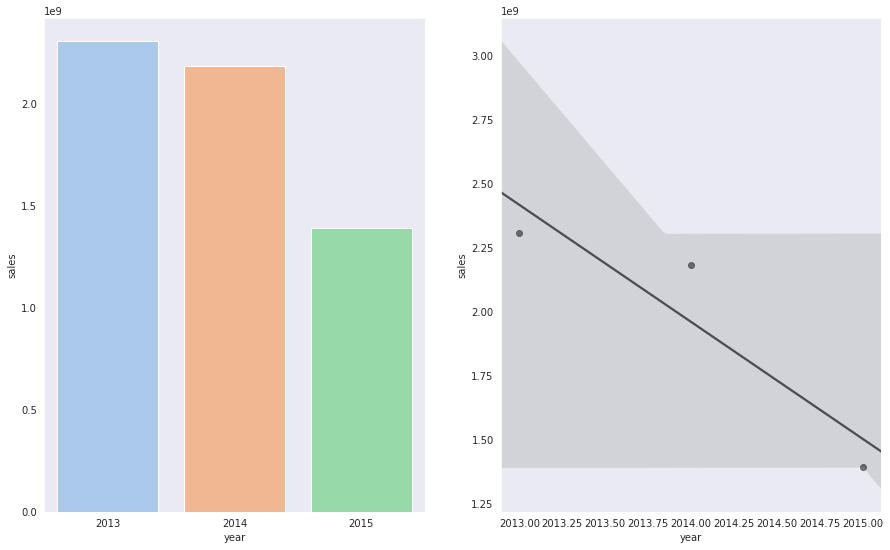

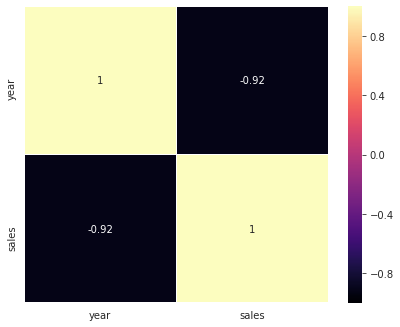

In [40]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

fig_h8 = plt.figure(figsize=(15, 20))
grid5 = gs.GridSpec(2, 2, fig_h8)

# ---------------------------------------------------------------------------------------------------------------

plt.subplot(grid5[0, 0])
sns.barplot(data=aux1, x='year', y='sales', palette='pastel');

plt.subplot(grid5[0, 1])
sns.regplot( data=aux1, x='year', y='sales', color=gray );

# ---------------------------------------------------------------------------------------------------------------

fig_h8b = plt.figure(figsize=(15, 12))
grid6 = gs.GridSpec(1, 1, fig_h8b)
plt.subplot(grid5[0, 0])
sns.heatmap( aux1.corr( method='pearson' ), linewidths=.5,
           vmin=-1, vmax=1, annot=True, cmap="magma");

### **H9.** Stores should sell more in the second half of the year.
**FALSE** Stores sell LESS in the SECOND HALF OF THE YEAR.

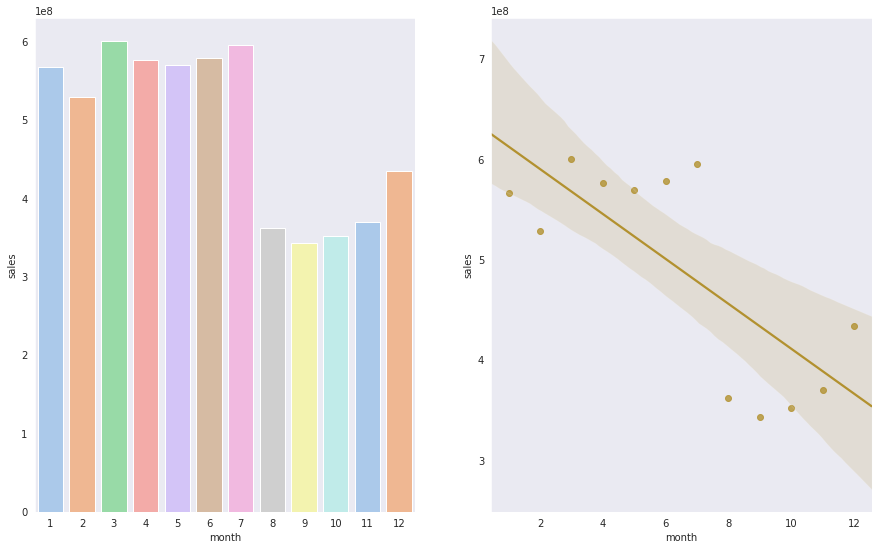

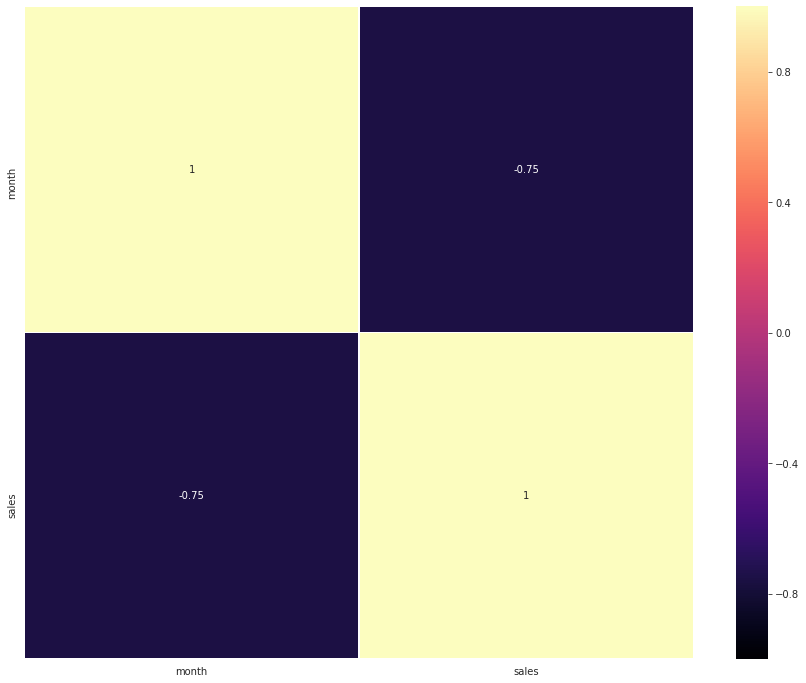

In [41]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

fig_h9 = plt.figure(figsize=(15, 20))
grid7 = gs.GridSpec(2, 2, fig_h9)

# ---------------------------------------------------------------------------------------------------------------

plt.subplot(grid7[0, 0])
sns.barplot(data=aux1, x='month', y='sales', palette='pastel' );

plt.subplot(grid7[0, 1])
sns.regplot(data=aux1, x='month', y='sales', color=brown );

# ---------------------------------------------------------------------------------------------------------------

fig_h9b = plt.figure(figsize=(15, 12))
grid8 = gs.GridSpec(1, 1, fig_h9b)
plt.subplot(grid8[0, 0])
sns.heatmap( aux1.corr( method='pearson' ), linewidths=.5,
           vmin=-1, vmax=1, annot=True, cmap="magma");

### **H10.** Stores should sell more after the 10th of each month.
**TRUE** Stores sell more after the 10th of each month.

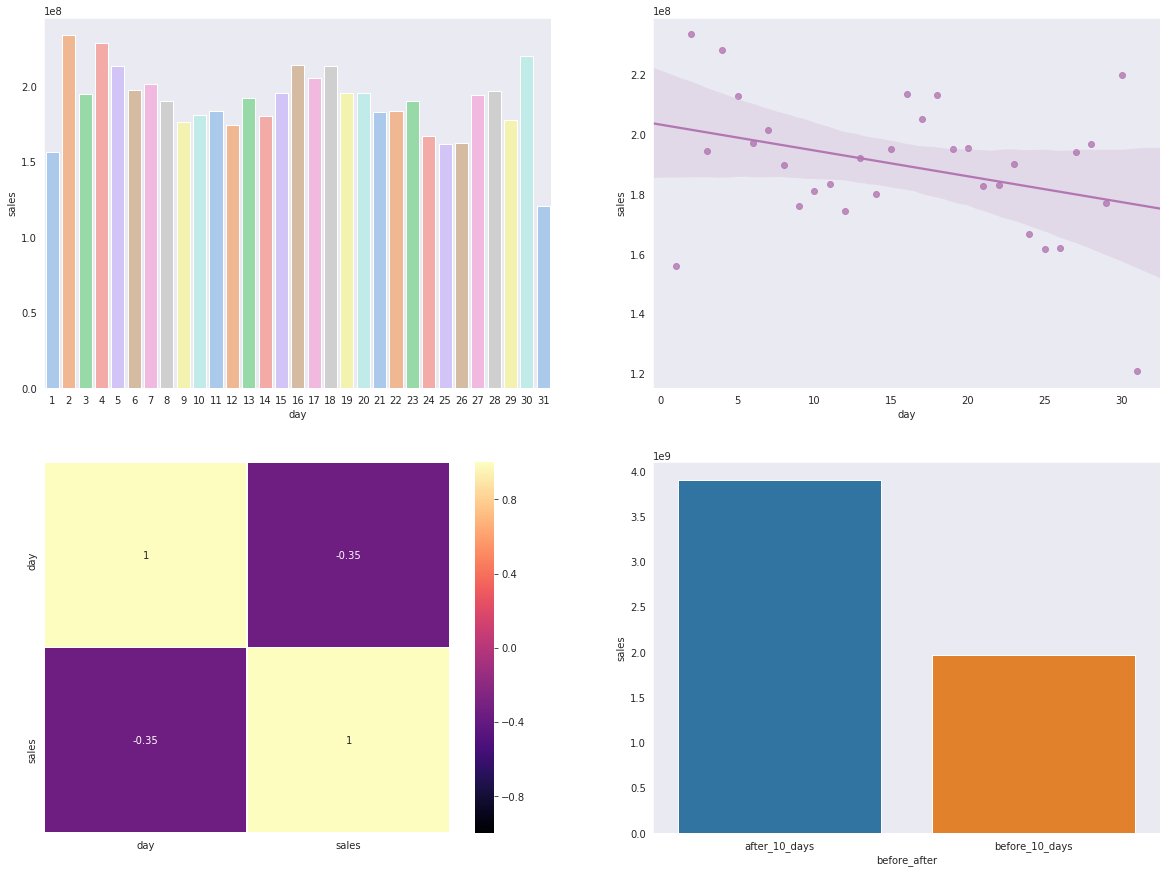

In [42]:
fig_h10, axes = plt.subplots(2, 2, figsize=(20, 15))
sns.set_style('dark')

# ---------------------------------------------------------------------------------------------------------------

aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()


sns.barplot( ax=axes[0, 0], data=aux1, x='day', y='sales', palette='pastel' );

sns.regplot( ax=axes[0, 1], data=aux1, x='day', y='sales', color=purple );

sns.heatmap(aux1.corr( method='pearson' ), linewidths=.5,
          vmin=-1, vmax=1, annot=True, cmap="magma",  ax=axes[1, 0]);

# ---------------------------------------------------------------------------------------------------------------


aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' 
                                         if x <= 10 
                                         else 'after_10_days' )

aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()


sns.barplot( ax=axes[1, 1], data=aux2, x='before_after', y='sales' );

### **H11.** Stores should sell less on weekends. 
**TRUE** Stores should sell less on weekends. 

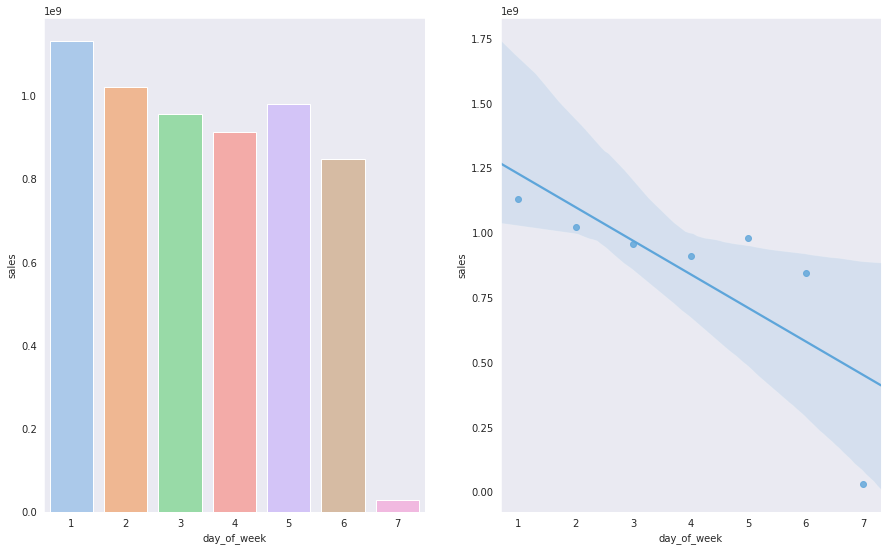

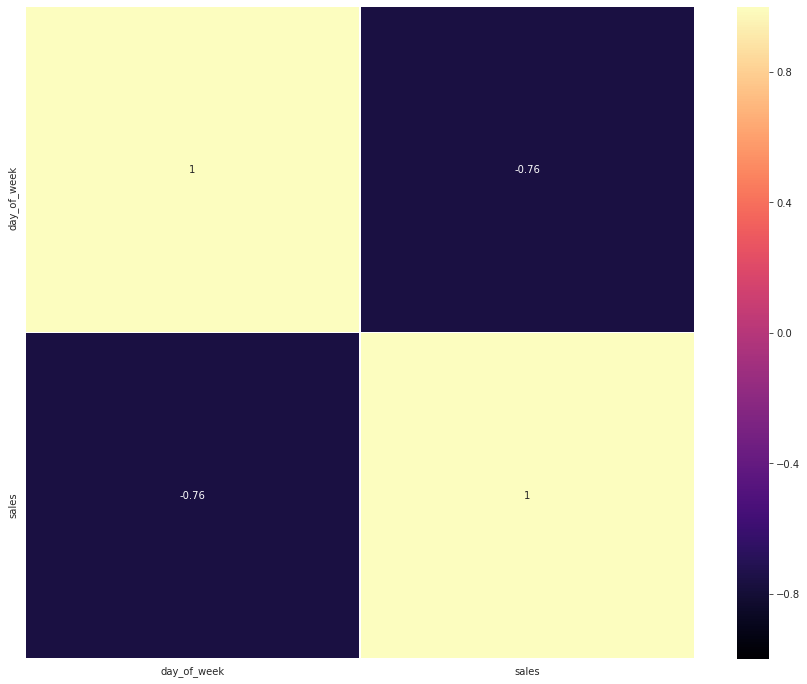

In [43]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()


fig_h11 = plt.figure(figsize=(15, 20))
grid9 = gs.GridSpec(2, 2, fig_h11)

# ---------------------------------------------------------------------------------------------------------------

plt.subplot(grid9[0, 0])
sns.barplot(data=aux1, x='day_of_week', y='sales', palette='pastel' );

plt.subplot(grid9[0, 1])
sns.regplot( data=aux1, x='day_of_week', y='sales', color=blue);

# ---------------------------------------------------------------------------------------------------------------

fig_h11b = plt.figure(figsize=(15, 12))
grid10 = gs.GridSpec(1, 1, fig_h11b)
plt.subplot(grid10[0, 0])
sns.heatmap( aux1.corr( method='pearson' ), linewidths=.5,
           vmin=-1, vmax=1, annot=True, cmap="magma");

### **H12.** Stores should sell less during school holidays.
**TRUE** Stores sell less during school holidays, except on July e August.

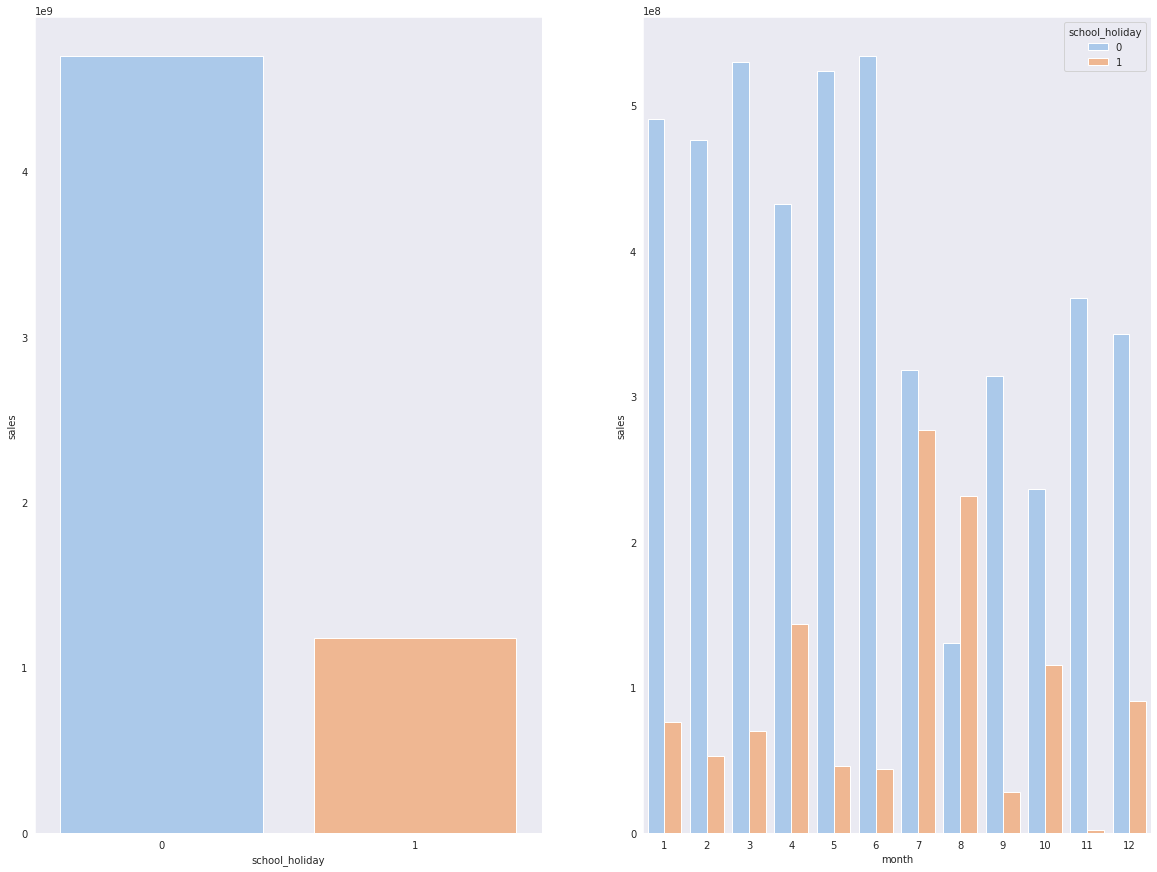

In [44]:
fig_h12, (ax1, ax2) = plt.subplots(1, 2, figsize = figsize)
sns.set_style('dark')

# ---------------------------------------------------------------------------------------------------------------

aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
sns.barplot( ax=ax1, data=aux1, x='school_holiday', y='sales', palette='pastel' );

# ---------------------------------------------------------------------------------------------------------------

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
sns.barplot( ax=ax2, data= aux2, x='month', y='sales', hue='school_holiday', palette='pastel' );

### 4.2.1 Hypothesis resume

In [45]:
resume = [
    ['Hipoteses', 'Conclusao', 'Relevancia'],
    ['H1', 'Falsa', 'Baixa'],
    ['H2', 'Falsa', 'Media'],
    ['H3', 'Falsa', 'Media'],
    ['H4', 'Falsa', 'Baixa'],
    ['H5', '-', '-'],
    ['H7', 'Falsa', 'Baixa'],
    ['H8', 'Falsa', 'Media'],
    ['H9', 'Falsa', 'Alta'],
    ['H10', 'Falsa', 'Alta'],
    ['H11', 'Verdadeira', 'Alta'],
    ['H12', 'Verdadeira', 'Alta'],
    ['H13', 'Verdadeira', 'Baixa'],
]
print(tabulate(resume, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3 Multivariate analysis

### 4.3.1 Numerical attributes

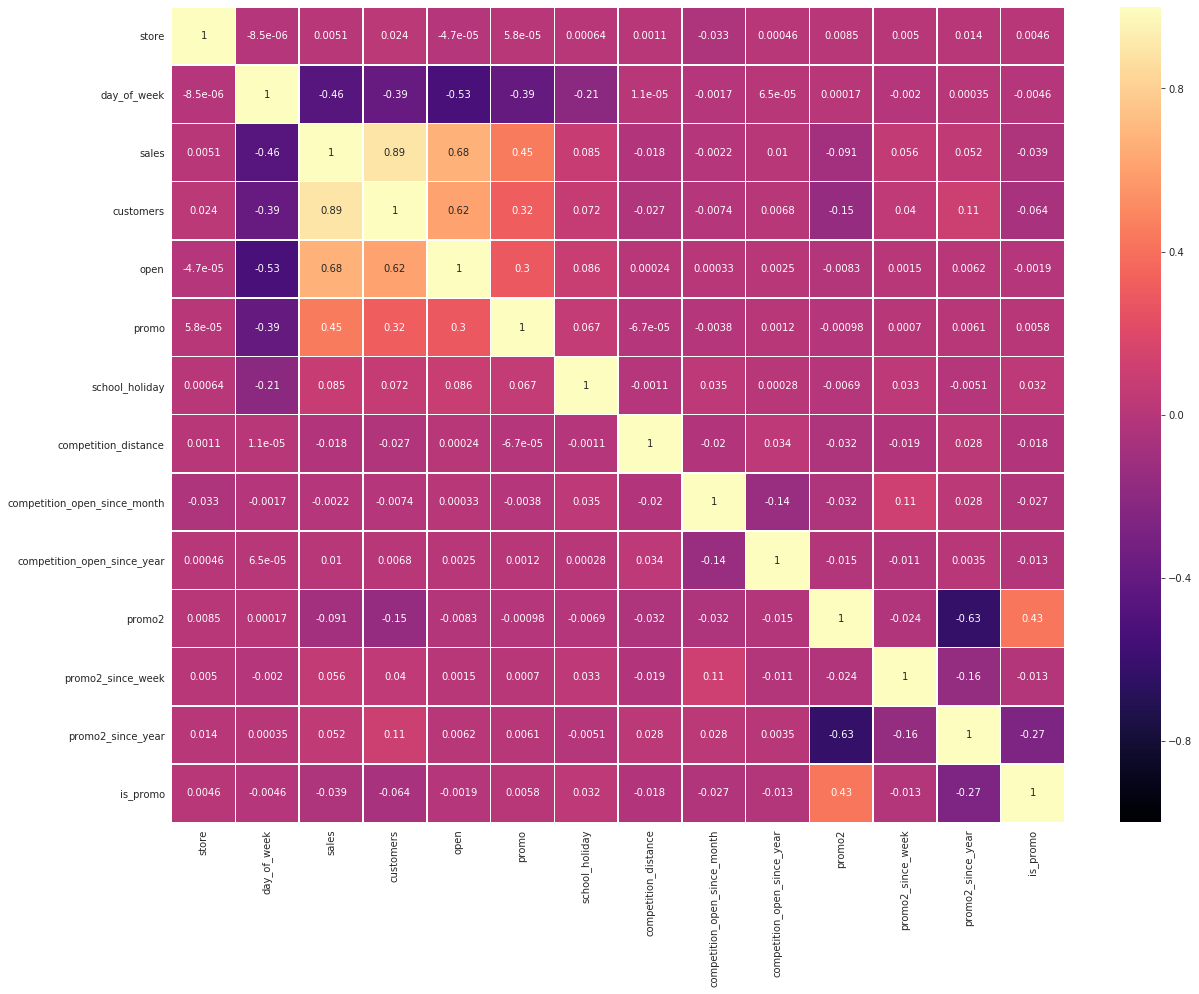

In [46]:
plt.figure(figsize=figsize)
correlation = num_attributes.corr(method='pearson')
heatmap_num = sns.heatmap(correlation, linewidths=.5,
                          vmin=-1, vmax=1, annot=True, cmap="magma")

### 4.3.2 Categorical attributes

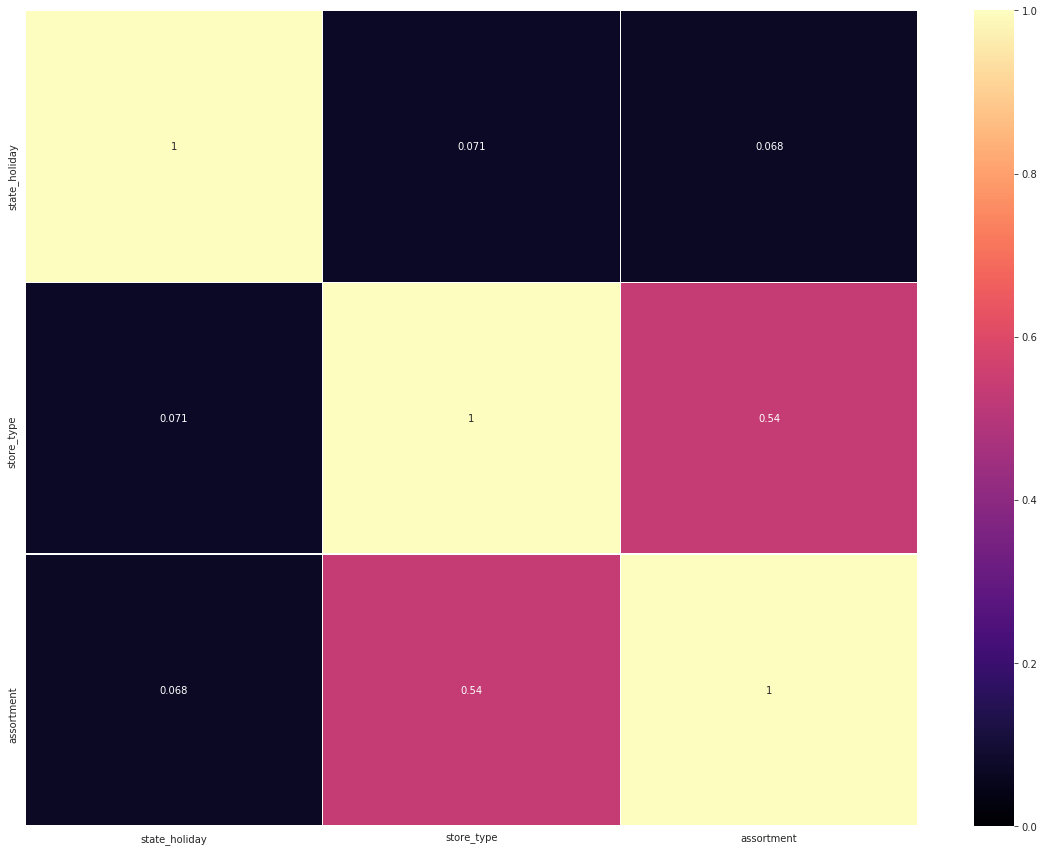

In [47]:
# only categorical data
c = df4.select_dtypes(include='object')

# Cramer's V calculation
c1 = cramers_v(c['state_holiday'], c['state_holiday'])
c2 = cramers_v(c['state_holiday'], c['store_type'])
c3 = cramers_v(c['state_holiday'], c['assortment'])

c4 = cramers_v(c['store_type'], c['state_holiday'])
c5 = cramers_v(c['store_type'], c['store_type'])
c6 = cramers_v(c['store_type'], c['assortment'])

c7 = cramers_v(c['assortment'], c['state_holiday'])
c8 = cramers_v(c['assortment'], c['store_type'])
c9 = cramers_v(c['assortment'], c['assortment'])

# Final dataset
d = pd.DataFrame({'state_holiday': [c1, c2, c3], 'store_type': [
                 c4, c5, c6], 'assortment': [c7, c8, c9]})
d = d.set_index(d.columns)

plt.figure(figsize=figsize)
sns.heatmap(d, linewidths=.5, vmin=0, vmax=1, annot=True, cmap="magma")

# 5.0 DATA PREPARATION

## 5.0.1 Dataset copy

In [48]:
df5 = df4.copy()

## 5.1 Normatilization

## 5.2 Rescaling

In [49]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(
    df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform(
    df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3 Transformation

### 5.3.1 Encoding

In [50]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response variable transformation

In [51]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Nature Transformation

In [52]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(
    lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(
    lambda x: np.cos(x * (2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(
    lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(
    lambda x: np.cos(x * (2. * np.pi/52)))

# 6.0 FEATURE SELECTIONFeature Selection

## 6.1 Dataset Copy

In [53]:
df6 = df5.copy()

## 6.2 Split DF into training and test dataset

In [54]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [55]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis = 1)

In [56]:
# Using the last 6 weeks in the dataset to use as test
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [57]:
#train data
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] > '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-20 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.3 Boruta as feature selector

In [58]:
"""
# *This phase took 1h to be done, to reduce the code execution time, this part of the code is commented*

# training and test dataset for Boruta
X_train_n = X_train.drop(['date', 'sales'], axis = 1).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor(n_jobs = -1)

# define boruta
boruta = BorutaPy (rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

"""

"\n# *This phase took 1h to be done, to reduce the code execution time, this part of the code is commented*\n\n# training and test dataset for Boruta\nX_train_n = X_train.drop(['date', 'sales'], axis = 1).values\ny_train_n = y_train.values.ravel()\n\n# define RandomForestRegressor\nrf = RandomForestRegressor(n_jobs = -1)\n\n# define boruta\nboruta = BorutaPy (rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)\n\n"

### 6.3.1 Best features from Boruta

In [59]:
"""
cols_selected = boruta.support_.tolist()

# best features
x_train_fs = x_train.drop(['date', 'sales'], axis = 1)
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))
"""

"\ncols_selected = boruta.support_.tolist()\n\n# best features\nx_train_fs = x_train.drop(['date', 'sales'], axis = 1)\ncols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()\n\n# not selected boruta\ncols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))\n"

In [60]:
# cols_selected_boruta

In [61]:
 # cols_not_selected_boruta

### 6.4 Manual feature selection

In [62]:
cols_selected = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos'
]

# columns to add
add_important_features = ['date', 'sales']

# cols_selected extended
cols_selected_full = cols_selected.copy()
cols_selected_full.extend(add_important_features)

# ----------------------------------------------------------------------------------------------------

cols_not_selected = [
    'is_promo',
    'school_holiday',
    'state_holiday_christmas',
    'state_holiday_easter_holiday',
    'state_holiday_public_holiday',
    'state_holiday_regular_day',
    'year'
]

# 7.0  MACHINE LEARNING

### 7.0.1 Train and test


In [63]:
x_train = X_train[cols_selected]
x_test = X_test[cols_selected]

# Time Series data preparation
x_training = X_train[cols_selected_full]

### 7.1 Average model

In [64]:
# model

aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']


#performance
baseline_result = ml_error('Average model', np.expm1(y_test), np.expm1(yhat_baseline) )
baseline_result

,Model name,MAE,MAPE,RMSE
0,Average model,1366.128351,0.452087,1854.263316


### 7.2 Linear regression model

In [65]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model name,MAE,MAPE,RMSE
0,Linear Regression,1865.27656,0.293219,2678.012082


### 7.3 Linear regression regularized model

In [66]:
# model
lrr = Lasso(alpha=0.01).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression Regularized', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model name,MAE,MAPE,RMSE
0,Linear Regression Regularized,1892.399394,0.290015,2752.314176


### 7.4 Random Forest Regressor

In [67]:
# model
rf = RandomForestRegressor(n_estimators= 100, n_jobs=-1, random_state=42).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.809877,0.100096,1011.299856


### 7.5 XGBooster Regressor

In [68]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators= 100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytree=0.9).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBooster Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model name,MAE,MAPE,RMSE
0,XGBooster Regressor,891.738089,0.129244,1312.013343


### 7.6 Linear regression model with cross validation

In [69]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2083.17 +/- 294.98,0.3 +/- 0.02,2958.87 +/- 466.72


### 7.7 Linear regression regularized model with cross validation 

In [70]:
lrr_result_cv = cross_validation( x_training, 5, 'Linear Regression Regularized', lrr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2083.17 +/- 294.98,0.3 +/- 0.02,2958.87 +/- 466.72


### 7.8 Random forest regressor with cross validation 

In [71]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose= False )
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,838.18 +/- 218.74,0.12 +/- 0.02,1256.87 +/- 319.67


### 7.9 XGBooster regressor with cross validation 

In [72]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose= False )
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1048.45 +/- 172.04,0.14 +/- 0.02,1513.27 +/- 234.33


### 7.10 Comparation between model's

#### 7.10.1 Single performance

In [73]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.809877,0.100096,1011.299856
0,XGBooster Regressor,891.738089,0.129244,1312.013343
0,Average model,1366.128351,0.452087,1854.263316
0,Linear Regression,1865.276560,0.293219,2678.012082
0,Linear Regression Regularized,1892.399394,0.290015,2752.314176


#### 7.10.2 Real performance - Cross validation

In [74]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv],ignore_index=True )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2083.17 +/- 294.98,0.3 +/- 0.02,2958.87 +/- 466.72
1,Linear Regression Regularized,2117.66 +/- 340.94,0.29 +/- 0.01,3061.89 +/- 503.23
2,Random Forest Regressor,838.18 +/- 218.74,0.12 +/- 0.02,1256.87 +/- 319.67
3,XGBoost Regressor,1048.45 +/- 172.04,0.14 +/- 0.02,1513.27 +/- 234.33


# 8.0 HYPERPARAMETER FINE TUNING

### 8.1 Random search

In [75]:
param = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
        'eta': [0.01, 0.03],
        'max_depth': [3, 5, 7],
        'subsample': [0.1, 0.5, 0.7],
        'colsample_bytree': [0.3, 0.5, 0.9],
        'min_child_weight': [3, 8,15]
        }


max_eval = 5

In [76]:
final_result = pd.DataFrame()

for i in range( max_eval ):
    # choose values for parameters randomly
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print( hp )
    
    # model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'], 
                                  eta=hp['eta'], 
                                  max_depth=hp['max_depth'], 
                                  subsample=hp['subsample'],
                                  colsample_bytee=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'] )

    # performance
    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
    final_result = pd.concat( [final_result, result] )
        
final_result

{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 8}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 8}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 8}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 7, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 3}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2



,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,910.46 +/- 125.43,0.13 +/- 0.01,1292.09 +/- 179.27
0,XGBoost Regressor,864.58 +/- 136.13,0.12 +/- 0.02,1236.09 +/- 195.75
0,XGBoost Regressor,911.81 +/- 125.69,0.13 +/- 0.01,1292.59 +/- 179.04
0,XGBoost Regressor,847.65 +/- 133.55,0.12 +/- 0.02,1218.21 +/- 184.03
0,XGBoost Regressor,905.33 +/- 128.91,0.13 +/- 0.01,1289.65 +/- 183.67


### 8.2 Final model

In [78]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.01,
    'max_depth': 7,
    'subsample': 0.5,
    'colsample_bytree': 0.3,
    'min_child_weight': 3 
        }

In [79]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model name,MAE,MAPE,RMSE
0,XGBoost Regressor,637.034899,0.09184,929.825572


In [84]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

0.014675104058280214

# 9.0 Error interpretation

In [87]:
df9 = X_test[cols_selected_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business performance

In [88]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [89]:
df92.sample(4)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
810,811,139038.250000,138659.722120,139416.777880,378.527880,0.085817
505,506,247776.203125,247254.020291,248298.385959,522.182834,0.069483
514,515,319206.750000,318455.422987,319958.077013,751.327013,0.087662
971,972,120898.609375,120577.351078,121219.867672,321.258297,0.102706


In [92]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,96832.453125,93401.039374,100263.866876,3431.413751,0.558327
908,909,220931.828125,213030.184770,228833.471480,7901.643355,0.524882
875,876,189543.828125,185491.661455,193595.994795,4052.166670,0.289340
182,183,199369.203125,197792.438563,200945.967687,1576.764562,0.257273
721,722,335735.750000,333963.496379,337508.003621,1772.253621,0.239432


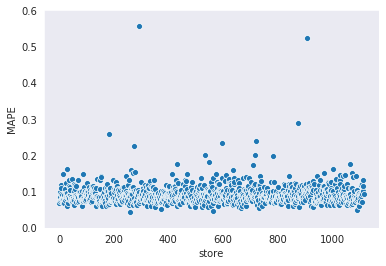

In [90]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

## 9.2 Total performance

In [91]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$273,202,091.39"
1,worst_scenario,"R$272,487,524.20"
2,best_scenario,"R$273,916,658.58"


## 9.3 Machine learning performance

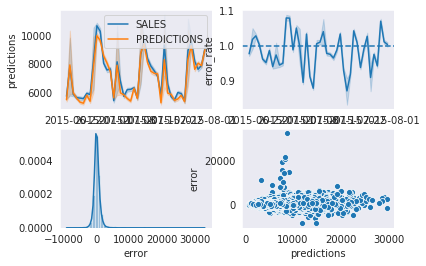

In [93]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']


plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

In [81]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open( '/home/gutto/Projects/rossmann_store_sales/model/model_rossmann.pkl', 'wb' ) )